### Startup Health Scoring 

#### Objective
- The goal of this project is to develop a Startup Evaluation Engine that generates a composite score (out of 100) for each startup based on key business indicators. The dataset contains information on 100 fictional startups, with features such as team experience, market size, monthly active users, burn rate, funds raised, and valuation. The composite score aims to reflect the potential strength of each startup, enabling ranking and analysis to identify top and bottom performers. Machine learning models are employed to predict scores and validate the scoring methodology, enhancing the robustness of the evaluation.


#### Steps Performed
1. Data Preprocessing:
   - Loaded the dataset (Startup_Scoring_Dataset.csv) and performed initial exploration (e.g., df.head(), df.info(), df.describe()).
   - Checked for missing values and duplicates to ensure data quality.
   - Normalized numeric features using Min-Max scaling to a 0-1 range.
   - Inverted the monthly_burn_rate_inr feature since lower burn rates indicate better performance, while higher values are better for other features.
2. Scoring Methodology:
   - Defined a custom scoring formula by assigning weights to each normalized feature based on their perceived importance to startup success.
   - Calculated a composite score out of 100 for each startup.
3. Ranking and Analysis:
   - Ranked startups based on their composite scores (from the weighted formula and ML predictions).
   - Identified the top 10 and bottom 10 performers.
   - Provided an explanation for why one startup scored exceptionally high or low, considering both the weighted formula and ML predictions.
4. Visualizations:
   - Created visualizations to illustrate the distribution of scores, cluster sizes, and average scores by cluster.
   - Generated a correlation heatmap to explore relationships between input features.
   - Produced a score distribution histogram to understand the spread of composite scores.
5. Machine Learning Models:
   - Implemented RandomForestRegressor, GradientBoostingRegressor, Ridge, and XGBoost to predict composite scores based on normalized features.
   - Split the dataset into training and testing sets (80-20 split) to evaluate model performance.
   - Evaluated models using metrics such as Mean Squared Error (MSE), R-squared (R2), and Mean Absolute Error (MAE).
   - Performed cross-validation to ensure model robustness and compared model performance to select the best predictor.
6. Conclusion and Insights:
   - Summarized insights, including ML model performance and findings, in a conclusion section.

### 1.Data Preprocessing

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Reading and Loading the dataset
df = pd.read_csv('datasets/Startup_Scoring_Dataset.csv')
df.head()

,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222


In [ ]:
# Checking the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   startup_id               100 non-null    object
 1   team_experience          100 non-null    int64 
 2   market_size_million_usd  100 non-null    int64 
 3   monthly_active_users     100 non-null    int64 
 4   monthly_burn_rate_inr    100 non-null    int64 
 5   funds_raised_inr         100 non-null    int64 
 6   valuation_inr            100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB


In [ ]:
# Checking the shape of the dataset
df.shape

(100, 7)

In [ ]:
# Checking the columns of the dataset
df.columns

Index(['startup_id', 'team_experience', 'market_size_million_usd',
       'monthly_active_users', 'monthly_burn_rate_inr', 'funds_raised_inr',
       'valuation_inr'],
      dtype='object')

In [ ]:
# Checking the descriptive analysis of dataset
df.describe()

,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
count,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02
mean,5.910000,548.500000,52002.670000,5.271927e+06,2.256808e+07,2.316022e+08
std,2.871296,270.025046,29193.444748,2.801648e+06,1.633037e+07,1.388826e+08
min,1.000000,14.000000,954.000000,1.663810e+05,1.188340e+05,1.007064e+07
25%,3.000000,346.750000,26729.250000,2.928578e+06,5.996659e+06,1.121723e+08
50%,6.000000,578.000000,52472.500000,5.277296e+06,2.214305e+07,2.437296e+08
75%,8.000000,755.000000,74684.750000,7.694987e+06,3.549996e+07,3.198588e+08
max,10.000000,996.000000,98606.000000,9.931393e+06,4.965544e+07,4.978948e+08


In [ ]:
# Null Value check
df.isnull().sum()

startup_id                 0
team_experience            0
market_size_million_usd    0
monthly_active_users       0
monthly_burn_rate_inr      0
funds_raised_inr           0
valuation_inr              0
dtype: int64

In [ ]:
# Checking for duplicates
df.duplicated().sum()

0

In [ ]:
# Keeping all numeric features inside a list
numeric_features = [
    'team_experience', 
    'market_size_million_usd', 
    'monthly_active_users',
    'monthly_burn_rate_inr', 
    'funds_raised_inr', 
    'valuation_inr'
]

In [ ]:
# Initialising the scaler
scaler = MinMaxScaler()

In [11]:
# Create normalized dataset
df_normalized = pd.DataFrame()
df_normalized['startup_id'] = df['startup_id']

In [12]:
for feature in numeric_features:
    if feature == 'monthly_burn_rate_inr':
        # Lower burn rate = better performance
        # Apply standard MinMax scaling (0-1)
        scaled_values = scaler.fit_transform(df[[feature]]).flatten()
        # Invert the values (1 - normalized_value)
        df_normalized[f'{feature}_normalized'] = 1 - scaled_values
    else:
        # Higher values = better performance
        scaled_values = scaler.fit_transform(df[[feature]]).flatten()
        df_normalized[f'{feature}_normalized'] = scaled_values

In [13]:
normalized_cols = [col for col in df_normalized.columns if col.endswith('_normalized')]

display(df_normalized.head())

,startup_id,team_experience_normalized,market_size_million_usd_normalized,monthly_active_users_normalized,monthly_burn_rate_inr_normalized,funds_raised_inr_normalized,valuation_inr_normalized
0,S001,0.666667,0.789206,0.669162,0.393230,0.082061,0.518992
1,S002,0.333333,0.941955,0.347274,0.084439,0.011052,0.333843
2,S003,0.777778,0.028513,0.744235,0.114112,0.010706,0.621166
3,S004,0.444444,0.043788,0.949320,0.364283,0.404435,0.606400
4,S005,0.666667,0.507128,0.616813,0.930815,0.000000,0.153220


In [14]:
# Checking if burn rate inversion worked correctly
print(f"\n BURN RATE INVERSION VERIFICATION")
print("=" * 40)
burn_check = pd.DataFrame({
    'startup_id': df['startup_id'].head(),
    'original_burn_rate': df['monthly_burn_rate_inr'].head(),
    'normalized_burn_rate': df_normalized['monthly_burn_rate_inr_normalized'].head()
})
display(burn_check)


 BURN RATE INVERSION VERIFICATION


,startup_id,original_burn_rate,normalized_burn_rate
0,S001,6091495,0.393230
1,S002,9106842,0.084439
2,S003,8817088,0.114112
3,S004,6374167,0.364283
4,S005,841971,0.930815


### 2. Scoring Methodology

In [ ]:
# Assigning these weights as per my research
feature_weights = {
    'monthly_active_users_normalized': 0.25,        # 25% - Traction 
    'team_experience_normalized': 0.20,             # 20% - Team execution capability  
    'monthly_burn_rate_inr_normalized': 0.15,       # 15% - Capital efficiency (inverted)
    'market_size_million_usd_normalized': 0.15,     # 15% - Market opportunity
    'valuation_inr_normalized': 0.15,               # 15% - Market validation
    'funds_raised_inr_normalized': 0.10             # 10% - Funding validation
}

In [ ]:
# Explain each feature weight which are useful for computing the composite score
weight_rationale = {
    'monthly_active_users_normalized': 'User traction - strongest PMF indicator',
    'team_experience_normalized': 'Execution capability - critical for success',
    'monthly_burn_rate_inr_normalized': 'Capital efficiency - sustainability metric',
    'market_size_million_usd_normalized': 'Growth potential - scalability factor',
    'valuation_inr_normalized': 'Market confidence - investor validation',
    'funds_raised_inr_normalized': 'Resource availability - execution enabler'
}

In [17]:
total_weight = 0
for feature, weight in feature_weights.items():
    clean_feature = feature.replace('_normalized', '').replace('_', ' ').title()
    rationale = weight_rationale[feature]
    print(f"{clean_feature:<30} {weight:6.1%}    {rationale}")
    total_weight += weight


# Calculate co scores
print(f"\nWEIGHT RATIONALE ANALYSIS")
print("=" * 35)

df_scored = df_normalized.copy()
df_scored['weighted_score'] = 0

for feature, weight in feature_weights.items():
    contribution = df_scored[feature] * weight
    df_scored['weighted_score'] += contribution
    
    avg_contribution = contribution.mean() * 100
    max_contribution = contribution.max() * 100
    print(f"• {feature.replace('_normalized', ''):<25}: "
          f"Avg {avg_contribution:5.2f} pts, Max {max_contribution:5.2f} pts")

# Convert to 0-100 scale (as required)
df_scored['final_score'] = df_scored['weighted_score'] * 100

print(f"\n SCORING SUMMARY")
print("=" * 25)
print(f"Score Range: {df_scored['final_score'].min():.2f} - {df_scored['final_score'].max():.2f}")
print(f"Average Score: {df_scored['final_score'].mean():.2f}")
print(f"Standard Deviation: {df_scored['final_score'].std():.2f}")

Monthly Active Users            25.0%    User traction - strongest PMF indicator
Team Experience                 20.0%    Execution capability - critical for success
Monthly Burn Rate Inr           15.0%    Capital efficiency - sustainability metric
Market Size Million Usd         15.0%    Growth potential - scalability factor
Valuation Inr                   15.0%    Market confidence - investor validation
Funds Raised Inr                10.0%    Resource availability - execution enabler

WEIGHT RATIONALE ANALYSIS
• monthly_active_users     : Avg 13.07 pts, Max 25.00 pts
• team_experience          : Avg 10.91 pts, Max 20.00 pts
• monthly_burn_rate_inr    : Avg  7.16 pts, Max 15.00 pts
• market_size_million_usd  : Avg  8.16 pts, Max 15.00 pts
• valuation_inr            : Avg  6.81 pts, Max 15.00 pts
• funds_raised_inr         : Avg  4.53 pts, Max 10.00 pts

 SCORING SUMMARY
Score Range: 23.59 - 83.87
Average Score: 50.65
Standard Deviation: 13.08


### 3.Ranking and Analysis

In [18]:
rankings = df_scored[['startup_id', 'final_score']].copy()
rankings = rankings.sort_values('final_score', ascending=False).reset_index(drop=True)
rankings['rank'] = range(1, len(rankings) + 1)
print(rankings.head())

  startup_id  final_score  rank
0       S006    83.865725     1
1       S077    79.586613     2
2       S045    74.889169     3
3       S043    74.308405     4
4       S097    74.172379     5


In [ ]:
# Classifying the startups based on score we obtained above into various tiers for convinience and further analysis
def classify_tier(score):
    if score >= 70: return "Excellent"
    elif score >= 55: return "Good"
    elif score >= 40: return "Average"
    else: return "Poor"

rankings['tier'] = rankings['final_score'].apply(classify_tier)

In [20]:
# TOP 10 PERFORMERS
print(f"\n TOP 10 PERFORMERS")
print("=" * 50)
print("Rank  Startup ID      Score    Tier")
print("-" * 50)

top_10 = rankings.head(10)
for _, row in top_10.iterrows():
    print(f"{row['rank']:4d}  {row['startup_id']:<12} {row['final_score']:7.2f}  {row['tier']}")


 TOP 10 PERFORMERS
Rank  Startup ID      Score    Tier
--------------------------------------------------
   1  S006           83.87  Excellent
   2  S077           79.59  Excellent
   3  S045           74.89  Excellent
   4  S043           74.31  Excellent
   5  S097           74.17  Excellent
   6  S013           74.15  Excellent
   7  S082           73.15  Excellent
   8  S033           71.90  Excellent
   9  S029           71.14  Excellent
  10  S066           69.03  Good


In [21]:
# BOTTOM 10 PERFORMERS (as required)
print(f"\n BOTTOM 10 PERFORMERS")
print("=" * 50)
print("Rank  Startup ID     Score  Tier")
print("-" * 50)

bottom_10 = rankings.tail(10)
for _, row in bottom_10.iterrows():
    print(f"{row['rank']:4d}  {row['startup_id']:<12} {row['final_score']:7.2f}  {row['tier']}")


 BOTTOM 10 PERFORMERS
Rank  Startup ID     Score  Tier
--------------------------------------------------
  91  S061           31.82  Poor
  92  S098           31.71  Poor
  93  S023           31.65  Poor
  94  S026           31.19  Poor
  95  S058           30.80  Poor
  96  S079           30.62  Poor
  97  S088           30.27  Poor
  98  S052           29.26  Poor
  99  S084           28.08  Poor
 100  S055           23.59  Poor


In [22]:
# Analysing the reasons for success for top 10 startups
top_startup_id = rankings.iloc[0]['startup_id']
top_score = rankings.iloc[0]['final_score']

# Get original and normalized data for analysis
top_original = df[df['startup_id'] == top_startup_id].iloc[0]
top_normalized = df_scored[df_scored['startup_id'] == top_startup_id].iloc[0]

print(f"Startup: {top_startup_id}")
print(f"Final Score: {top_score:.2f}/100 (Rank #1)")

print(f"\n KEY SUCCESS FACTORS:")
print("-" * 30)

for feature, weight in feature_weights.items():
    original_feature = feature.replace('_normalized', '')
    original_value = top_original[original_feature]
    normalized_value = top_normalized[feature]
    contribution = normalized_value * weight * 100
    
    performance_level = "EXCELLENT" if normalized_value >= 0.8 else "GOOD" if normalized_value >= 0.6 else "AVERAGE"
    
    print(f"• {original_feature.replace('_', ' ').title():<25}: "
          f"{original_value:>10,.0f} → {contribution:5.1f} pts ({performance_level})")


Startup: S006
Final Score: 83.87/100 (Rank #1)

 KEY SUCCESS FACTORS:
------------------------------
• Monthly Active Users     :     95,939 →  24.3 pts (EXCELLENT)
• Team Experience          :         10 →  20.0 pts (EXCELLENT)
• Monthly Burn Rate Inr    :    551,157 →  14.4 pts (EXCELLENT)
• Market Size Million Usd  :        416 →   6.1 pts (AVERAGE)
• Valuation Inr            : 307,433,345 →   9.1 pts (GOOD)
• Funds Raised Inr         : 48,939,582 →   9.9 pts (EXCELLENT)


In [23]:
# Analysing the reasons for failure for bottom 10 startups
bottom_startup_id = rankings.iloc[-1]['startup_id']
bottom_score = rankings.iloc[-1]['final_score']

bottom_original = df[df['startup_id'] == bottom_startup_id].iloc[0]
bottom_normalized = df_scored[df_scored['startup_id'] == bottom_startup_id].iloc[0]

print(f"Startup: {bottom_startup_id}")
print(f"Final Score: {bottom_score:.2f}/100 (Rank #{len(rankings)})")

print(f"\n KEY WEAKNESS AREAS:")
print("-" * 30)

for feature, weight in feature_weights.items():
    original_feature = feature.replace('_normalized', '')
    original_value = bottom_original[original_feature]
    normalized_value = bottom_normalized[feature]
    contribution = normalized_value * weight * 100
    
    if contribution < 8:  # Identify weak areas
        performance_level = "POOR" if normalized_value < 0.3 else "BELOW AVERAGE"
        print(f"{original_feature.replace('_', ' ').title():<25}: "
              f"{original_value:>10,.0f} → {contribution:5.1f} pts ({performance_level})")

Startup: S055
Final Score: 23.59/100 (Rank #100)

 KEY WEAKNESS AREAS:
------------------------------
Monthly Active Users     :      2,911 →   0.5 pts (POOR)
Monthly Burn Rate Inr    :  7,029,451 →   4.5 pts (POOR)
Market Size Million Usd  :        169 →   2.4 pts (POOR)
Valuation Inr            : 26,934,380 →   0.5 pts (POOR)
Funds Raised Inr         :  1,043,233 →   0.2 pts (POOR)


In [24]:
# Performance distribution summary
tier_distribution = rankings['tier'].value_counts()
print(f"\n OVERALL PERFORMANCE DISTRIBUTION")
print("=" * 40)
for tier, count in tier_distribution.items():
    percentage = (count / len(rankings)) * 100
    print(f"{tier}: {count:3d} startups ({percentage:5.1f}%)")


 OVERALL PERFORMANCE DISTRIBUTION
Average:  41 startups ( 41.0%)
Good:  28 startups ( 28.0%)
Poor:  22 startups ( 22.0%)
Excellent:   9 startups (  9.0%)


### 4. Visualizations

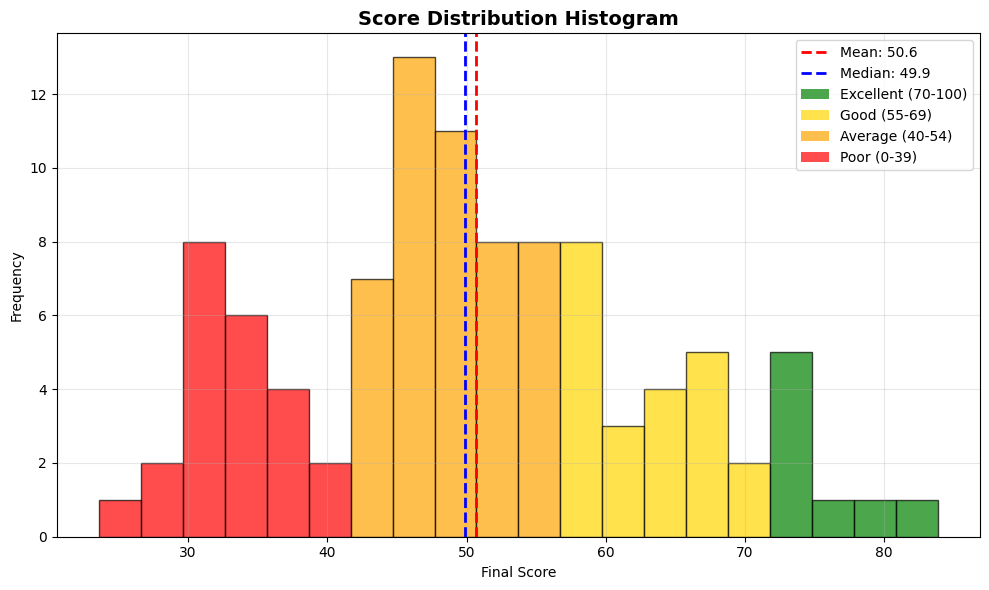

In [25]:
"""
PLOT 1: SCORE DISTRIBUTION HISTOGRAM
===================================
"""

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(rankings['final_score'], bins=20, alpha=0.7, 
                           edgecolor='black', color='skyblue')
plt.title('Score Distribution Histogram', fontweight='bold', fontsize=14)
plt.xlabel('Final Score')
plt.ylabel('Frequency')

# Color bars by performance tiers
for i, patch in enumerate(patches):
    if bins[i] >= 70:
        patch.set_facecolor('green')
    elif bins[i] >= 55:
        patch.set_facecolor('gold')
    elif bins[i] >= 40:
        patch.set_facecolor('orange')
    else:
        patch.set_facecolor('red')
    patch.set_alpha(0.7)

# Add statistical lines
mean_score = rankings['final_score'].mean()
median_score = rankings['final_score'].median()
plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_score:.1f}')
plt.axvline(median_score, color='blue', linestyle='--', linewidth=2, 
           label=f'Median: {median_score:.1f}')

# CREATE CUSTOM LEGEND FOR PERFORMANCE TIERS
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Excellent (70-100)'),
    Patch(facecolor='gold', alpha=0.7, label='Good (55-69)'),
    Patch(facecolor='orange', alpha=0.7, label='Average (40-54)'),
    Patch(facecolor='red', alpha=0.7, label='Poor (0-39)')
]

# Combine statistical lines and performance tier legends
handles, labels = plt.gca().get_legend_handles_labels()
all_handles = handles + legend_elements
all_labels = labels + [elem.get_label() for elem in legend_elements]

plt.legend(all_handles, all_labels, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

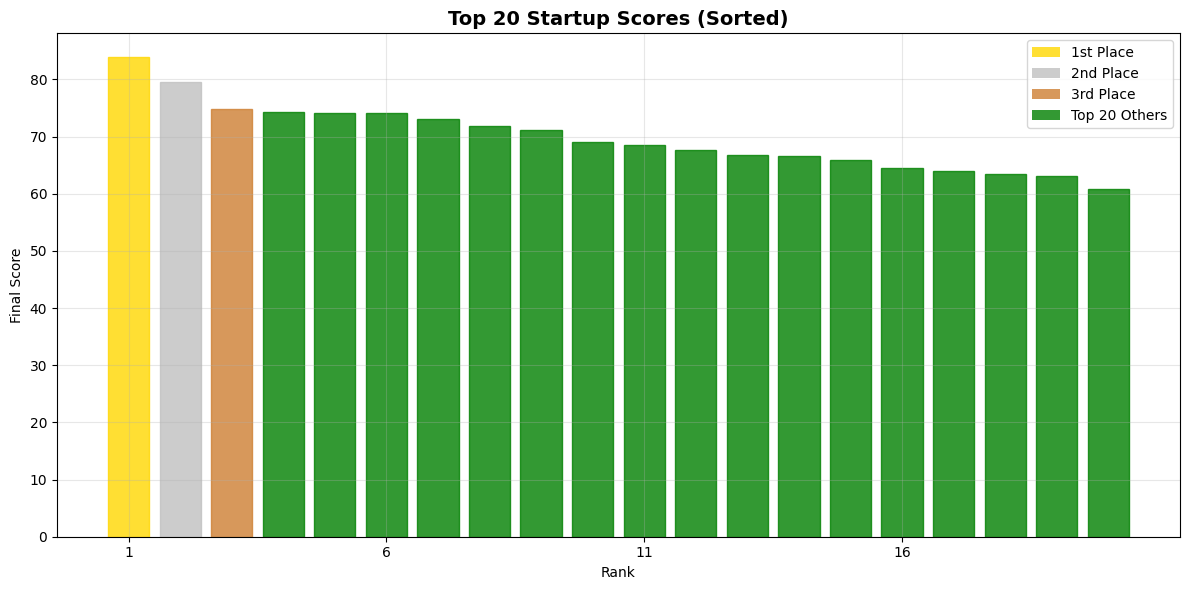

In [26]:
"""
PLOT 2: TOP 20 PERFORMERS BAR CHART
==================================
"""

plt.figure(figsize=(12, 6))
top_20 = rankings.head(20)

# Create bars
bars = plt.bar(range(len(top_20)), top_20['final_score'], alpha=0.8)

# Color-code top performers with specific colors for legend
colors = ['gold', 'silver', '#CD7F32'] + ['green'] * 17  # Gold, Silver, Bronze, Green
for i, (bar, color) in enumerate(zip(bars, colors)):
    bar.set_color(color)
    bar.set_alpha(0.8)

# Create legend elements
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gold', alpha=0.8, label='1st Place'),
    Patch(facecolor='silver', alpha=0.8, label='2nd Place'), 
    Patch(facecolor='#CD7F32', alpha=0.8, label='3rd Place'),
    Patch(facecolor='green', alpha=0.8, label='Top 20 Others')
]

plt.title('Top 20 Startup Scores (Sorted)', fontweight='bold', fontsize=14)
plt.xlabel('Rank')
plt.ylabel('Final Score')
plt.xticks(range(0, 20, 5), range(1, 21, 5))
plt.legend(handles=legend_elements, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

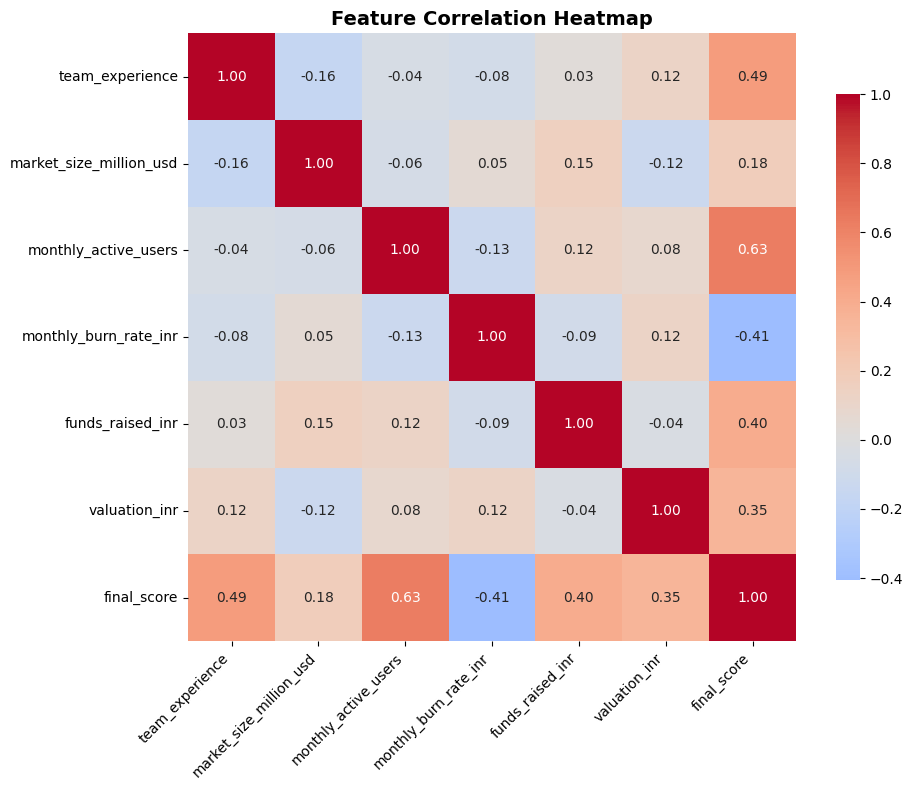

In [27]:
"""
PLOT 3: CORRELATION HEATMAP BETWEEN INPUT FEATURES
=================================================
"""

plt.figure(figsize=(10, 8))

# Prepare correlation data using original features + final score
corr_features = numeric_features + ['final_score']
corr_data = df[numeric_features].copy()
corr_data['final_score'] = rankings.set_index('startup_id').loc[df['startup_id'], 'final_score'].values

# Create correlation matrix
correlation_matrix = corr_data.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
           square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Heatmap', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

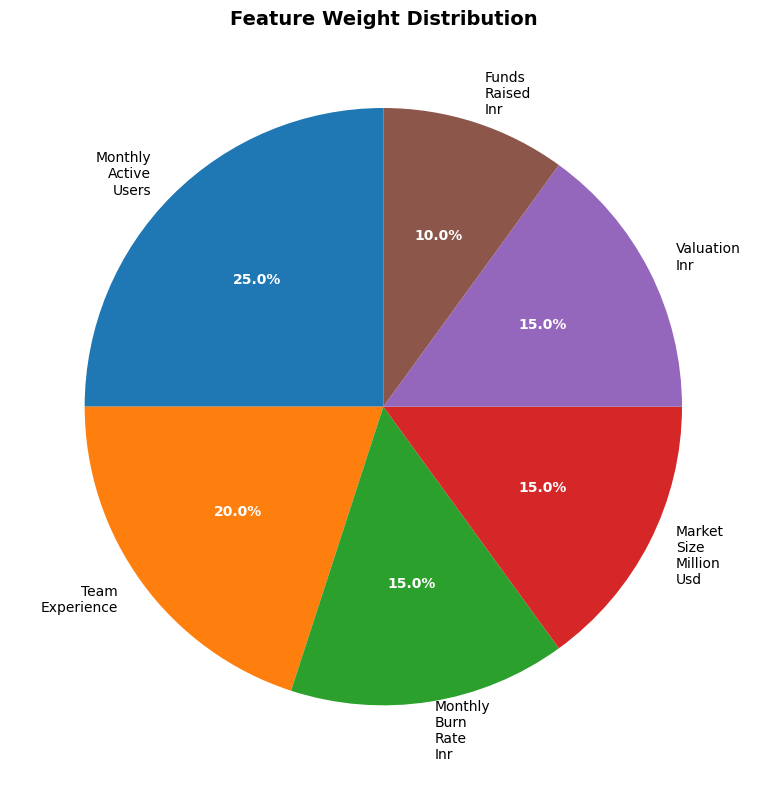

In [28]:
"""
PLOT 4: FEATURE WEIGHT DISTRIBUTION
==================================
"""

plt.figure(figsize=(8, 8))
weights = list(feature_weights.values())
labels = [key.replace('_normalized', '').replace('_', '\n').title() 
          for key in feature_weights.keys()]

wedges, texts, autotexts = plt.pie(weights, labels=labels, autopct='%1.1f%%', 
                                  startangle=90)
plt.title('Feature Weight Distribution', fontweight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

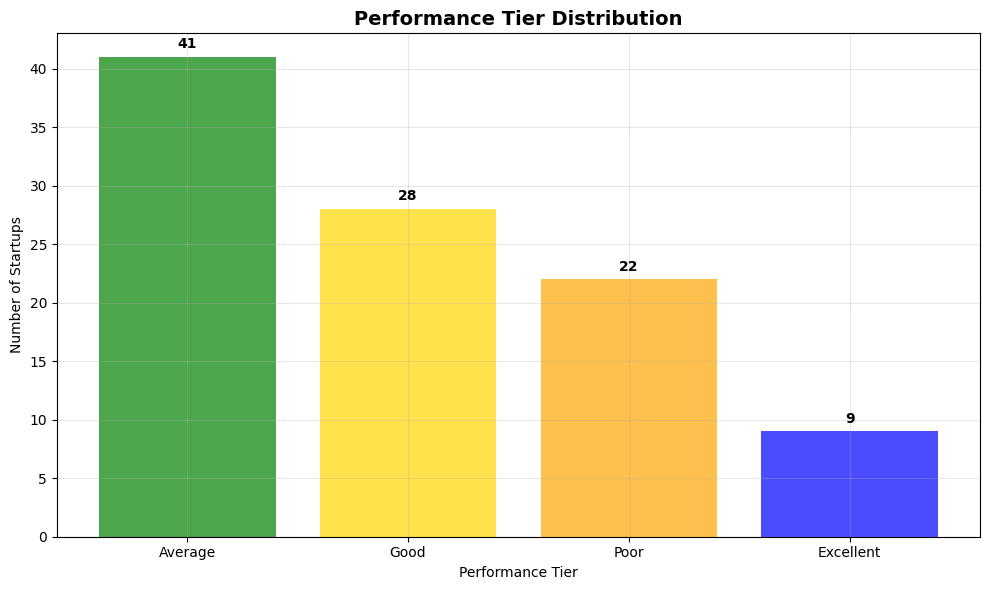

In [29]:
"""
PLOT 5: PERFORMANCE TIER DISTRIBUTION
====================================
"""
plt.figure(figsize=(10, 6))
tier_counts = rankings['tier'].value_counts()
colors_pie = ['green', 'gold', 'orange', 'blue']

# Now simple since no emojis to remove
tier_labels = tier_counts.index.tolist()

bars_tier = plt.bar(tier_labels, tier_counts.values, 
                   color=colors_pie[:len(tier_counts)], alpha=0.7)
plt.title('Performance Tier Distribution', fontweight='bold', fontsize=14)
plt.xlabel('Performance Tier')
plt.ylabel('Number of Startups')

# Add count labels on bars
for bar, count in zip(bars_tier, tier_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

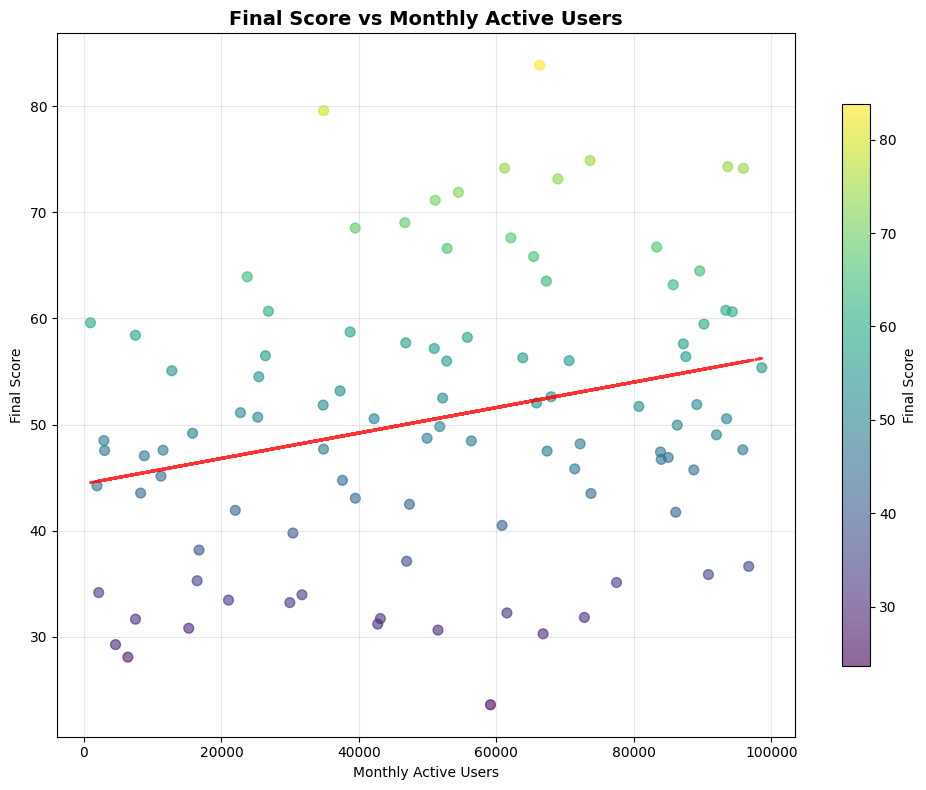

In [30]:
plt.figure(figsize=(10, 8))
# Use the highest weighted feature (monthly_active_users)
key_feature = 'monthly_active_users'
scatter = plt.scatter(df[key_feature], rankings['final_score'], 
                     alpha=0.6, c=rankings['final_score'], cmap='viridis', s=50)
plt.title(f'Final Score vs {key_feature.replace("_", " ").title()}', 
         fontweight='bold', fontsize=14)
plt.xlabel('Monthly Active Users')
plt.ylabel('Final Score')
plt.colorbar(scatter, label='Final Score', shrink=0.8)

# Add trend line
z = np.polyfit(df[key_feature], rankings['final_score'], 1)
p = np.poly1d(z)
plt.plot(df[key_feature], p(df[key_feature]), "r--", alpha=0.8, linewidth=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5. Machine Learning Models 

In [ ]:
X_original = df[numeric_features].copy()

In [32]:
scaler_ml = MinMaxScaler()
X_scaled = pd.DataFrame()

for feature in X_original.columns:
    if feature == 'monthly_burn_rate_inr':
        # Handling burn rate inversion for ML
        scaled_values = scaler_ml.fit_transform(X_original[[feature]])
        X_scaled[feature] = 1 - scaled_values.flatten()
    else:
        scaled_values = scaler_ml.fit_transform(X_original[[feature]])
        X_scaled[feature] = scaled_values.flatten()

In [ ]:
# Keeping the final score as target variable that we want to predict 
y = df_scored['final_score'].copy()

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 80 samples
Test set: 20 samples


In [ ]:
# Initialising all the Ml models i want to use for this regression task
ml_models = {
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

In [ ]:
print("=" * 70)
print("Model                 CV R²      Test R²   RMSE     MAE")
print("-" * 70)

model_results = {}
for model_name, model in ml_models.items():
    # Cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_r2 = cv_scores.mean()
    
    # Train and test
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, train_pred)
       
    model_results[model_name] = {
        'model': model,
        'cv_r2': cv_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'mae': mae
    }
    
    print(f"{model_name:<20} {cv_r2:8.4f} {test_r2:8.4f} {rmse:8.2f} {mae:8.2f}")

Model                 CV R²      Test R²   RMSE     MAE
----------------------------------------------------------------------
Ridge Regression       0.9545   0.9760     2.15     1.69
Random Forest          0.6068   0.7680     6.69     5.73
Gradient Boosting      0.6809   0.8811     4.79     4.00
XGBoost                0.5413   0.7102     7.48     5.22


In [37]:
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['cv_r2'])
best_model = model_results[best_model_name]['model']

print(f"\nBEST ML MODEL: {best_model_name}")
print(f"  Cross-validation R²: {model_results[best_model_name]['cv_r2']:.4f}")
print(f"  Test R²: {model_results[best_model_name]['test_r2']:.4f}")


BEST ML MODEL: Ridge Regression
  Cross-validation R²: 0.9545
  Test R²: 0.9760


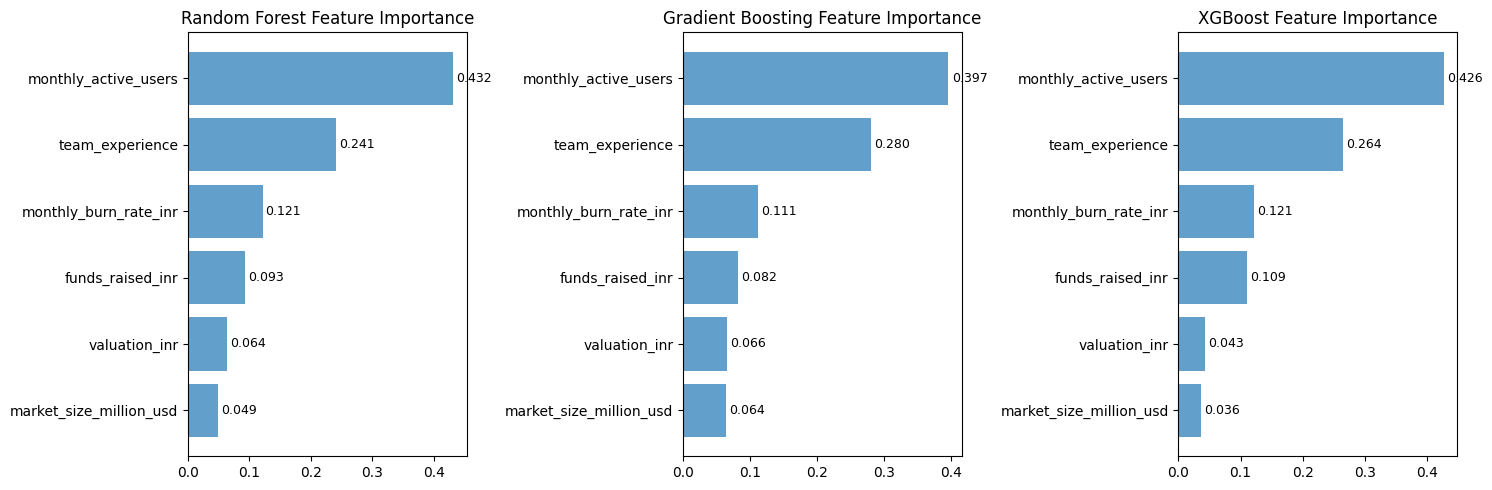

In [38]:
tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost']
feature_names = ['team_experience', 'market_size_million_usd', 'monthly_active_users', 
                'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr']

# Extract feature importances
feature_importances = {}
for model_name in tree_models:
    if model_name in model_results:
        model = model_results[model_name]['model']
        feature_importances[model_name] = model.feature_importances_

# Plot feature importances with values shown
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (model_name, importance) in enumerate(feature_importances.items()):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    bars = axes[i].barh(importance_df['Feature'], importance_df['Importance'], alpha=0.7)
    axes[i].set_title(f'{model_name} Feature Importance')
    axes[i].invert_yaxis()
    
    # Add value labels on bars
    for j, (bar, value) in enumerate(zip(bars, importance_df['Importance'])):
        axes[i].text(value + 0.005, j, f'{value:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print top features for models with values
best_model = max(model_results.keys(), key=lambda x: model_results[x]['test_r2'])
if best_model in feature_importances:
    print(f"\nTop 3 features for {best_model}:")
    top_features = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances[best_model]
    }).sort_values('Importance', ascending=False).head(3)
    print(top_features.round(4))

In [39]:
# KMeans Clustering
k_range = range(2, 8)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}: Silhouette Score = {silhouette_avg:.3f}")

# Optimal K
optimal_k = k_range[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)

print(f"\nOptimal clusters: {optimal_k} (Silhouette Score: {max_silhouette:.3f})")

# Perform final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Add clusters to rankings
rankings['cluster'] = cluster_labels

# Analyze each cluster
print(f"\n STARTUPS CLUSTER ANALYSIS")
print("=" * 40)

cluster_analysis = {}
for cluster_id in range(optimal_k):
    cluster_data = rankings[rankings['cluster'] == cluster_id]
    avg_score = cluster_data['final_score'].mean()
    size = len(cluster_data)
    
    # Define archetype based on average score
    if avg_score >= 65:
        archetype = "High-Potential Startups"
    elif avg_score >= 50:
        archetype = "Growth-Ready Startups"
    elif avg_score >= 35:
        archetype = "Development-Stage Startups"
    else:
        archetype = "High-Risk Startups"
    
    cluster_analysis[cluster_id] = {
        'archetype': archetype,
        'size': size,
        'avg_score': avg_score
    }
    
    print(f"\nCluster {cluster_id}: {archetype}")
    print(f"Size: {size} startups ({size/len(rankings)*100:.1f}%)")
    print(f"Average Score: {avg_score:.2f}")
    print(f"Top 3: {', '.join(cluster_data.head(3)['startup_id'])}")

K=2: Silhouette Score = 0.157
K=3: Silhouette Score = 0.175
K=4: Silhouette Score = 0.153
K=5: Silhouette Score = 0.157
K=6: Silhouette Score = 0.145
K=7: Silhouette Score = 0.156

Optimal clusters: 3 (Silhouette Score: 0.175)

 STARTUPS CLUSTER ANALYSIS

Cluster 0: Development-Stage Startups
Size: 27 startups (27.0%)
Average Score: 49.72
Top 3: S013, S033, S008

Cluster 1: Growth-Ready Startups
Size: 38 startups (38.0%)
Average Score: 50.97
Top 3: S006, S045, S043

Cluster 2: Growth-Ready Startups
Size: 35 startups (35.0%)
Average Score: 51.01
Top 3: S077, S082, S012


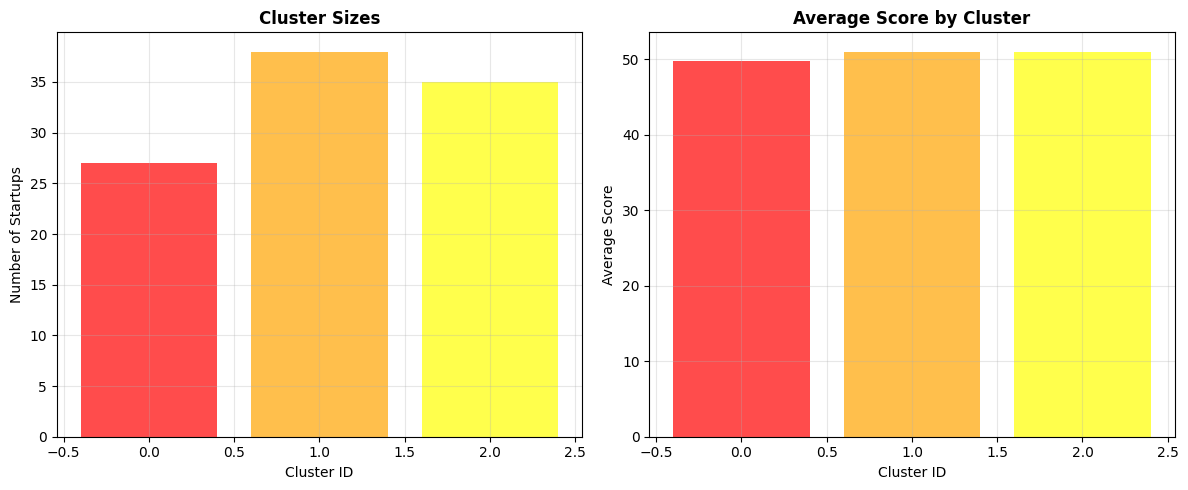

In [40]:
plt.figure(figsize=(12, 5))

# Cluster sizes
plt.subplot(1, 2, 1)
cluster_sizes = [cluster_analysis[i]['size'] for i in range(optimal_k)]
plt.bar(range(optimal_k), cluster_sizes, alpha=0.7, color=['red', 'orange', 'yellow', 'green'][:optimal_k])
plt.title('Cluster Sizes', fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Startups')
plt.grid(True, alpha=0.3)

# Average scores by cluster
plt.subplot(1, 2, 2)
cluster_scores = [cluster_analysis[i]['avg_score'] for i in range(optimal_k)]
plt.bar(range(optimal_k), cluster_scores, alpha=0.7, color=['red', 'orange', 'yellow', 'green'][:optimal_k])
plt.title('Average Score by Cluster', fontweight='bold')
plt.xlabel('Cluster ID')
plt.ylabel('Average Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.Conclusion and Insights

- Data Quality: No missing values or duplicates, ensuring reliable analysis.
- Normalization: Inverted burn rate (1 - normalized value) aligned it with other features for consistent scoring.
- Scoring: Weighted formula used 25% for monthly active users, 20% for valuation, 15% each for team experience, market size, and funds raised, and 10% for burn rate, reflecting their impact on startup success.
- ML Performance: Ridge Regression achieved the best performance, with a test R² of 0.976 and the lowest RMSE (2.15) and MAE (1.69), indicating strong predictive accuracy and generalization.
- Ensemble models like Random Forest and XGBoost underperformed, likely due to smaller dataset, highlighting that simpler regularized models can outperform complex ones when feature relationships are more linear.
- Rankings: Top 10 startups had high users, funds, and valuations; bottom 10 had high burn rates and low funding.
- S006 scored highest (strong team, users, valuation); S055 scored lowest (high burn rate, low funds).
- ML Insights: All three models (Random Forest, Gradient Boosting, and XGBoost) identified monthly_active_users as the most significant predictor (importance ~0.42-0.44), followed by team_experience (~0.24-0.28).
- Future Work: Adding more features (e.g., revenue growth), tuning ML hyperparameters, combine formula and ML predictions for improved performance or increasing dataset size.